M: k=1.169, beta_diff=-0.0049, alpha=0.2776, R²=0.83
F: k=0.934, beta_diff=-0.0062, alpha=0.4026, R²=0.86


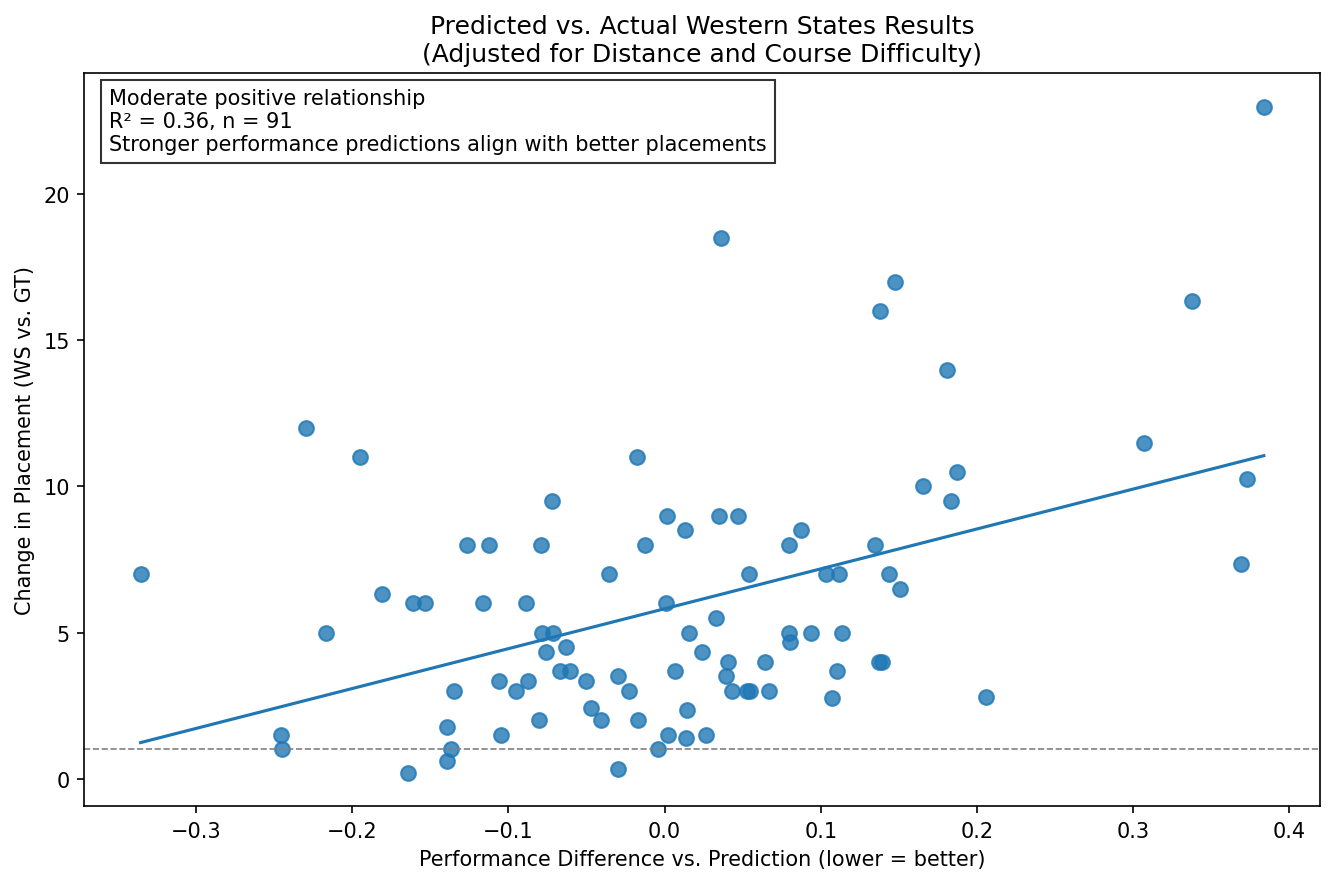

                  coef  std_err        t  p>|t|
const           5.8135   0.4034  14.4120    0.0
delta_fatigue  13.6510   2.8914   4.7213    0.0


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1) Load dataset
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2) Normalize column names and clean times
# -------------------------------------------------------------------
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

# Create unified difficulty column name
if "diff_index" in df.columns:
    df["diff_index"] = pd.to_numeric(df["diff_index"], errors="coerce")
elif "gt_diff_index" in df.columns:
    df["diff_index"] = pd.to_numeric(df["gt_diff_index"], errors="coerce")
else:
    raise ValueError("No difficulty index column found (expected 'diff_index' or 'gt_diff_index').")

# --- Time conversion helper ---
def to_seconds(t):
    if pd.isna(t):
        return np.nan
    s = str(t)
    if ":" in s:
        try:
            h, m, sec = s.split(":")
            return int(h)*3600 + int(m)*60 + float(sec)
        except Exception:
            return np.nan
    try:
        return float(s) * 24 * 3600  # fraction-of-day format
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3) Distance mapping (km)
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9
df = df.dropna(subset=["gt_distance_km"])

# -------------------------------------------------------------------
# 4) Fit gender-specific Riegel model with difficulty control
# -------------------------------------------------------------------
params_by_gender = {}
for g in ['M','F']:
    sub = df[df['gt_gender']==g].dropna(subset=['gt_sec','ws_sec','gt_distance_km','diff_index'])
    if sub.empty:
        continue
    sub["log_ratio"] = np.log(sub["ws_sec"]/sub["gt_sec"])
    sub["log_dist_ratio"] = np.log(160.9/sub["gt_distance_km"])
    X = sm.add_constant(sub[["log_dist_ratio","diff_index"]])
    y = sub["log_ratio"]
    res = sm.OLS(y, X).fit()
    params_by_gender[g] = {
        'alpha': res.params['const'],
        'k': res.params['log_dist_ratio'],
        'beta_diff': res.params['diff_index']
    }
    print(f"{g}: k={res.params['log_dist_ratio']:.3f}, beta_diff={res.params['diff_index']:.4f}, alpha={res.params['const']:.4f}, R²={res.rsquared:.2f}")

# -------------------------------------------------------------------
# 5) Predict WS times and compute ΔFatigue
# -------------------------------------------------------------------
def predict_ws_time_diffadj(row):
    p = params_by_gender.get(row['gt_gender'])
    if p is None or pd.isna(row['gt_distance_km']) or pd.isna(row['diff_index']) or pd.isna(row['gt_sec']):
        return np.nan
    log_dist = np.log(row['ws_distance_km'] / row['gt_distance_km'])
    log_ratio = p['alpha'] + p['k']*log_dist + p['beta_diff']*row['diff_index']
    ratio = np.exp(log_ratio)
    return row['gt_sec'] * ratio

df['ws_pred_sec'] = df.apply(predict_ws_time_diffadj, axis=1)
df['delta_fatigue'] = (df['ws_sec'] - df['ws_pred_sec']) / df['ws_pred_sec']
df['rank_ratio'] = df['ws_gender_rank'] / df['gt_gender_rank']
valid = df.dropna(subset=['delta_fatigue','rank_ratio'])

# -------------------------------------------------------------------
# 6) OLS regression (rank ratio ~ ΔFatigue)
# -------------------------------------------------------------------
X = sm.add_constant(valid[['delta_fatigue']])
y = valid['rank_ratio']
model = sm.OLS(y, X).fit()

# -------------------------------------------------------------------
# 7) Scatter plot with regression line
# -------------------------------------------------------------------
m, b = np.polyfit(valid['delta_fatigue'], valid['rank_ratio'], 1)
x_line = np.linspace(valid['delta_fatigue'].min(), valid['delta_fatigue'].max(), 200)
y_line = m * x_line + b

plt.figure(figsize=(9, 6), dpi=150)
plt.scatter(valid['delta_fatigue'], valid['rank_ratio'], s=50, alpha=0.8)
plt.plot(x_line, y_line, linewidth=1.5)
plt.axhline(1.0, linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Performance Difference vs. Prediction (lower = better)")
plt.ylabel("Change in Placement (WS vs. GT)")
plt.title("Predicted vs. Actual Western States Results\n(Adjusted for Distance and Course Difficulty)")

beta = model.params['delta_fatigue']
se = model.bse['delta_fatigue']
p = model.pvalues['delta_fatigue']
r2 = model.rsquared
n = int(valid.shape[0])
p_display = f"{p:.3f}" if p >= 0.001 else "<0.001"
text = (
    "Moderate positive relationship\n"
    "R² = 0.36, n = 91\n"
    "Stronger performance predictions align with better placements"
)
# text = f"β = {beta:.2f} (SE {se:.2f})\np = {p_display}\nR² = {r2:.2f}, n = {n}"
plt.text(0.02, 0.98, text, transform=plt.gca().transAxes,
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.8))
plt.tight_layout()

# plt.savefig('python_images/predicted_vs_actual_reigel_diff_index.png')

plt.show()

# -------------------------------------------------------------------
# 8) Coefficient table
# -------------------------------------------------------------------
coef_table = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p>|t|": model.pvalues
}).round(4)
print(coef_table)

In [5]:
import scipy.stats as stats
vr = valid.dropna(subset=["delta_fatigue","ws_gender_rank"])
r_s, p_s = stats.spearmanr(vr["delta_fatigue"], vr["ws_gender_rank"])
print(f"Spearman (ΔFatigue vs WS gender rank): r={r_s:.3f}, p={p_s:.4g}, n={len(vr)}")

Spearman (ΔFatigue vs WS gender rank): r=0.474, p=2.018e-06, n=91


In [2]:
# 1) Course-type map
course_map = {
    'Black Canyon': 'Fast/Runnable Desert',
    'Javelina': 'Fast/Runnable Desert',
    'Bandera': 'Fast/Runnable Desert',

    'Western States': 'California/WS-Style',
    'The Canyons': 'California/WS-Style',
    'Grindstone': 'California/WS-Style',

    'UTMB': 'Technical/Alpine Europe',
    'CCC': 'Technical/Alpine Europe',
    'Festival Des Templiers': 'Technical/Alpine Europe',
    'Nice Cote d Azur': 'Technical/Alpine Europe',

    'Doi Inthanon': 'Humid/Tropical Mountain',
    'Tarawera': 'Humid/Tropical Mountain',
    'Chianti (UTCC)': 'Humid/Tropical Mountain'
}
col_race = "gt_race_name" if "gt_race_name" in df.columns else "race_name"
col_gender = "gt_gender" if "gt_gender" in df.columns else "gender"
df["course_type"] = df[col_race].map(course_map)

# 2) Time parsing
def parse_time_to_seconds(val):
    if pd.isna(val):
        return np.nan
    s = str(val)
    if ":" in s:
        try:
            h, m, sec = s.split(":")
            return int(h)*3600 + int(m)*60 + int(float(sec))
        except Exception:
            pass
    try:
        f = float(s)
        return f * 24 * 3600  # fraction of a day → seconds
    except Exception:
        return np.nan

df["gt_sec"] = df["GT_Finish_Time"].apply(parse_time_to_seconds) if "GT_Finish_Time" in df.columns else np.nan
df["ws_sec"] = df["WS_Finish_Time"].apply(parse_time_to_seconds) if "WS_Finish_Time" in df.columns else np.nan

# Distances
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df[col_race].map(distance_map)
df["ws_distance_km"] = 160.9

# 3) Fit Riegel (by gender), optionally controlling for diff_index
use_diff = "diff_index" in df.columns
if use_diff:
    df["diff_index"] = pd.to_numeric(df["diff_index"], errors="coerce")

params_by_gender = {}
for g in ["M", "F"]:
    needed = ["gt_sec", "ws_sec", "gt_distance_km"]
    if use_diff:
        needed.append("diff_index")
    sub = df[(df[col_gender] == g)].dropna(subset=needed).copy()
    if sub.empty:
        continue
    sub["log_ratio"] = np.log(sub["ws_sec"]/sub["gt_sec"])
    sub["log_dist_ratio"] = np.log(sub["ws_distance_km"]/sub["gt_distance_km"])
    X_cols = ["log_dist_ratio"] + (["diff_index"] if use_diff else [])
    X = sm.add_constant(sub[X_cols])
    y = sub["log_ratio"]
    res = sm.OLS(y, X).fit()
    params = {"alpha": res.params.get("const", 0.0), "k": res.params.get("log_dist_ratio", 0.0)}
    if use_diff:
        params["beta_diff"] = res.params.get("diff_index", 0.0)
    params_by_gender[g] = params

# 4) Predict WS time + delta_fatigue
def predict_ws_time_diffadj(row):
    p = params_by_gender.get(row.get(col_gender))
    if p is None or pd.isna(row.get("gt_sec")) or pd.isna(row.get("gt_distance_km")):
        return np.nan
    log_dist = np.log(row.get("ws_distance_km") / row.get("gt_distance_km"))
    log_ratio = p["alpha"] + p["k"] * log_dist
    if use_diff and not pd.isna(row.get("diff_index")):
        log_ratio += p.get("beta_diff", 0.0) * row.get("diff_index")
    return row.get("gt_sec") * np.exp(log_ratio)

df["ws_pred_sec"] = df.apply(predict_ws_time_diffadj, axis=1)
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]

# 5) Summaries (adjusted only)
finishers = df[(df["ws_status"] == "Finisher") & df["delta_fatigue"].notna() & df["course_type"].notna()].copy()

summary_adj = (
    finishers.groupby(["course_type", col_gender])
      .agg(
          n_finishers=("ws_sec", "count"),
          median_delta=("delta_fatigue", "median"),
          mean_delta=("delta_fatigue", "mean"),
          pct_better=("delta_fatigue", lambda x: (x < 0).mean()),
          median_ws_gender_rank=("ws_gender_rank", "median")
      )
      .reset_index()
      .sort_values(["course_type", col_gender])
)


# 6) Visuals — adjusted only
plt.figure(figsize=(9,6))
sns.barplot(data=summary_adj, x="course_type", y="median_delta", hue=col_gender, palette={"F":"pink","M":"steelblue"})
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.title("Median ΔFatigue by Course Type × Gender\n(lower = better; difficulty-adjusted)")
plt.ylabel("Median ΔFatigue = (WS − Pred) / Pred")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
sns.barplot(data=summary_adj, x="course_type", y="pct_better", hue=col_gender, palette={"F":"pink","M":"steelblue"})
plt.title("Share Performing Better Than Predicted by Course Type × Gender\n(ΔFatigue < 0)")
plt.ylabel("Proportion Better-than-Predicted")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=finishers, x="course_type", y="delta_fatigue", hue=col_gender, palette={"F":"pink","M":"steelblue"})
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.title("ΔFatigue Distribution by Course Type × Gender\n(lower = better; difficulty-adjusted)")
plt.ylabel("ΔFatigue = (WS − Pred) / Pred")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

KeyError: 'race_name'

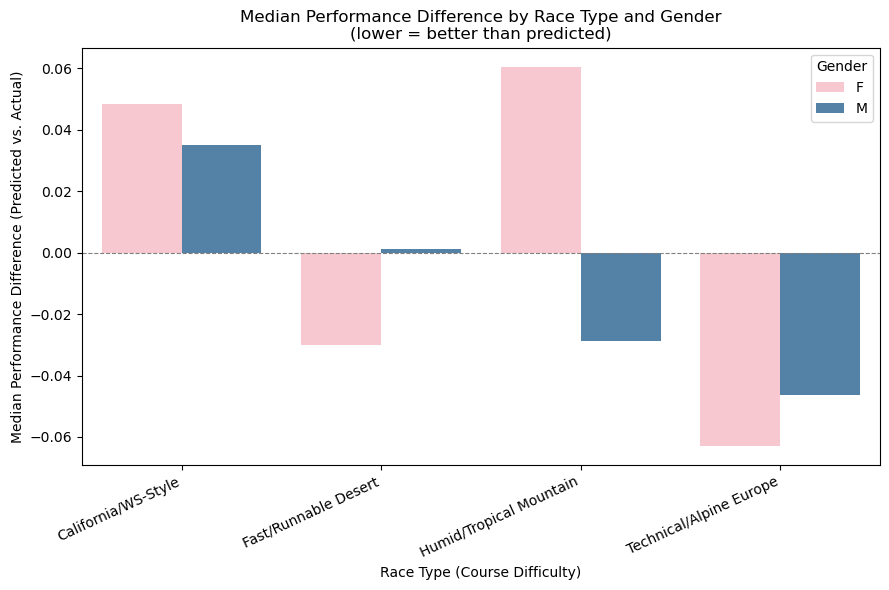

In [13]:
# --- Bar plot for Median ΔFatigue by Course Type and Gender ---
plt.figure(figsize=(9, 6))
sns.barplot(data=summary_adj, x="course_type", y="median_delta", hue=col_gender, palette={"F": "pink", "M": "steelblue"})
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.title("Median Performance Difference by Race Type and Gender\n(lower = better than predicted)")
plt.ylabel("Median Performance Difference (Predicted vs. Actual)")
plt.xlabel("Race Type (Course Difficulty)")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

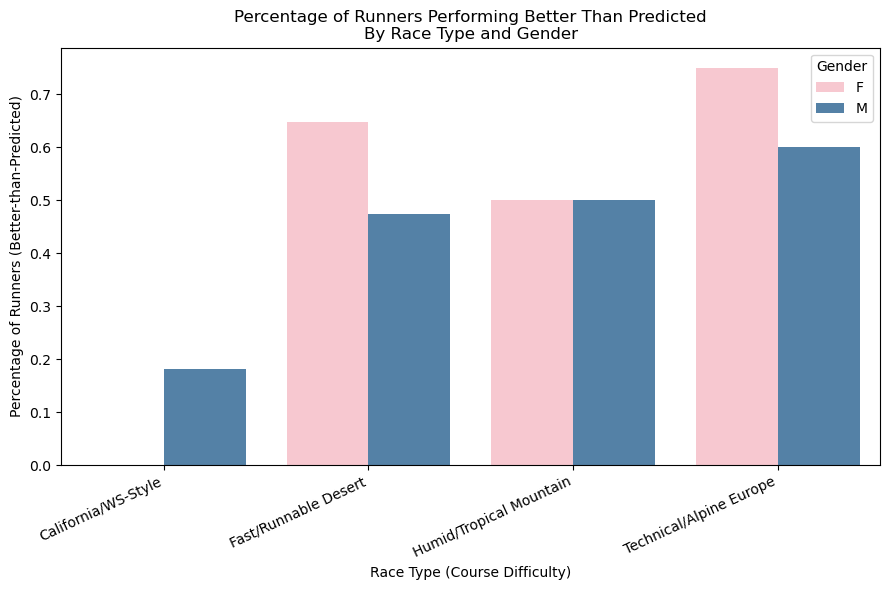

In [14]:
# --- Bar plot for Percentage of Runners Better Than Predicted ---
plt.figure(figsize=(9, 6))
sns.barplot(data=summary_adj, x="course_type", y="pct_better", hue=col_gender, palette={"F": "pink", "M": "steelblue"})
plt.title("Percentage of Runners Performing Better Than Predicted\nBy Race Type and Gender")
plt.ylabel("Percentage of Runners (Better-than-Predicted)")
plt.xlabel("Race Type (Course Difficulty)")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

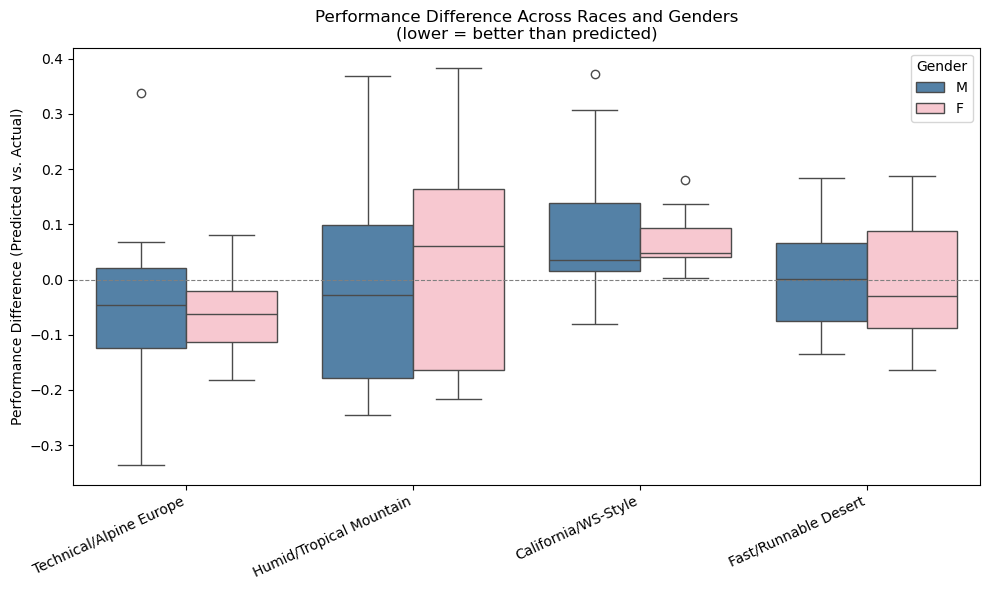

In [19]:
# --- Box plot for Distribution of ΔFatigue by Course Type and Gender ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=finishers, x="course_type", y="delta_fatigue", hue=col_gender, palette={"F": "pink", "M": "steelblue"})
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.title("Performance Difference Across Races and Genders\n(lower = better than predicted)")
plt.ylabel("Performance Difference (Predicted vs. Actual)")
plt.xlabel("")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()

plt.savefig('python_images/boxplot_reigel_diff_index.png', dpi = 300)

plt.show()

M: k=1.040, beta_diff=-0.0089, alpha=0.5620, R²=0.87
F: k=0.715, beta_diff=-0.0117, alpha=0.7919, R²=0.89
                            OLS Regression Results                            
Dep. Variable:             rank_ratio   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     20.36
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           1.58e-13
Time:                        20:08:47   Log-Likelihood:                -509.36
No. Observations:                 162   AIC:                             1029.
Df Residuals:                     157   BIC:                             1044.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

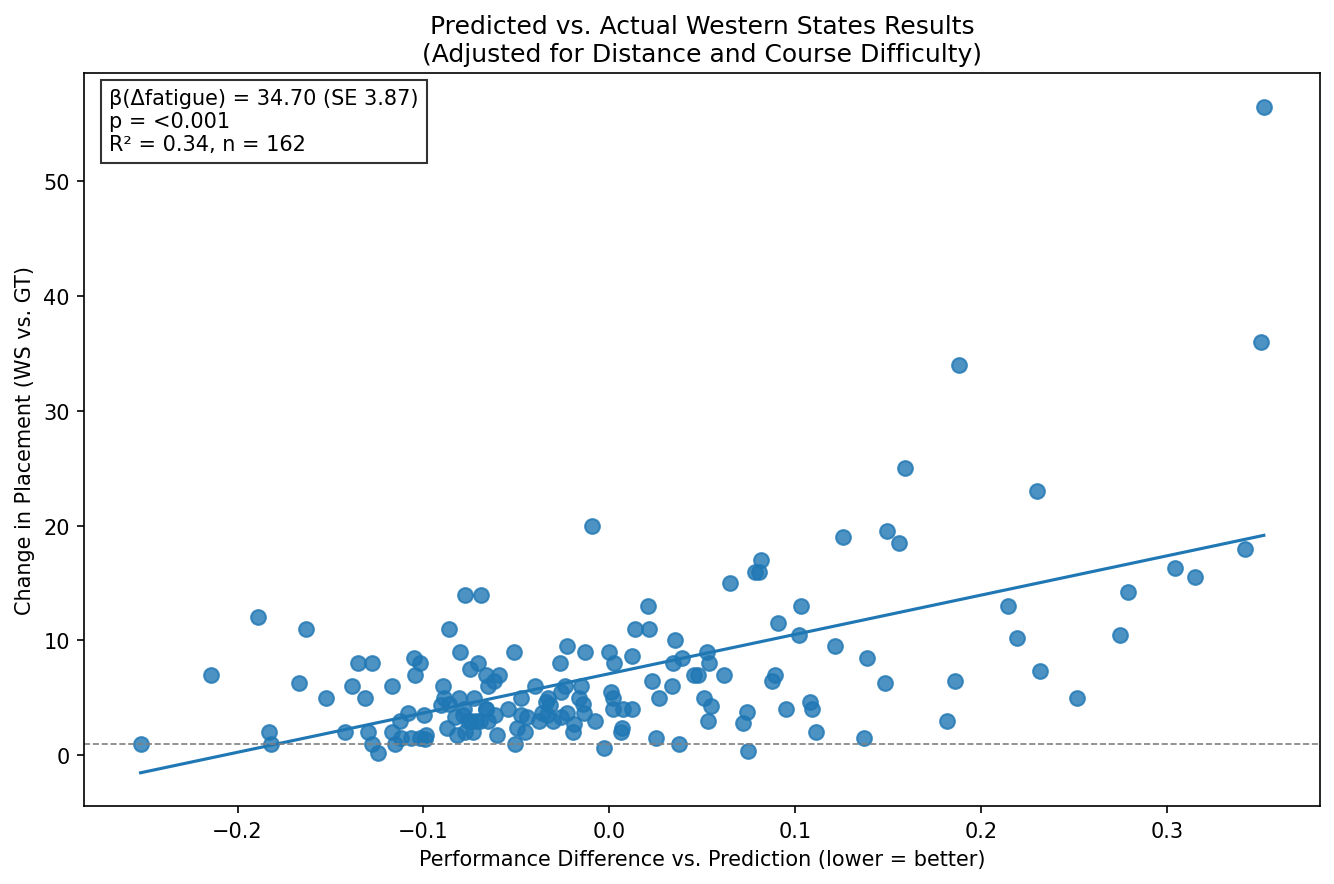

                  coef  std_err       t   p>|t|
const           8.0735   1.3950  5.7876  0.0000
delta_fatigue  34.7015   3.8744  8.9567  0.0000
Diff_Index     -0.0319   0.0313 -1.0216  0.3085
Num_WS_Finish   0.5024   0.5763  0.8717  0.3847
Days_to_WS      0.0013   0.0054  0.2326  0.8164


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1) Load dataset
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\master\master_csv\gt_master_table.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2) Normalize column names and clean times
# -------------------------------------------------------------------
df["Gender_Rank"] = pd.to_numeric(df["Gender_Rank"], errors="coerce")
df["WS_Gender_Rank"] = pd.to_numeric(df["WS_Gender_Rank"], errors="coerce")

# --- difficulty index normalization (uses new Diff_Index column) ---
if "Diff_Index" in df.columns:
    df["Diff_Index"] = pd.to_numeric(df["Diff_Index"], errors="coerce")
elif "gt_diff_index" in df.columns:
    # fallback if an old column name ever appears
    df["Diff_Index"] = pd.to_numeric(df["gt_diff_index"], errors="coerce")
else:
    raise ValueError("No difficulty index column found (expected 'Diff_Index' or 'gt_diff_index').")

# --- Time conversion helper ---
def to_seconds(t):
    if pd.isna(t):
        return np.nan
    s = str(t)
    # handle HH:MM:SS
    if ":" in s:
        try:
            h, m, sec = s.split(":")
            return int(h)*3600 + int(m)*60 + float(sec)
        except Exception:
            return np.nan
    # handle Excel / fraction-of-day numeric format
    try:
        return float(s) * 24 * 3600
    except Exception:
        return np.nan

df["gt_sec"] = df["GT_Finish_Time"].apply(to_seconds)
df["ws_sec"] = df["WS_Finish_Time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3) Distance mapping (km) – UPDATED to use Actual_Dist
# -------------------------------------------------------------------
# In the new gt_master_table, Actual_Dist already holds the race distance
# in miles (those 62.64 / 108.69 etc match your earlier table), so just convert:
df["gt_distance_km"] = df["Actual_Dist"] * 1.60934

# Western States distance (kept as a constant)
df["ws_distance_km"] = 162.24

# Drop any rows without a mapped GT distance
df = df.dropna(subset=["gt_distance_km"])

# -------------------------------------------------------------------
# 4) Fit gender-specific Riegel model with difficulty control
# -------------------------------------------------------------------
params_by_gender = {}
for g in ["M", "F"]:
    sub = df[df["Gender"] == g].dropna(subset=["gt_sec", "ws_sec", "gt_distance_km", "Diff_Index"]).copy()
    if sub.empty:
        continue

    sub["log_ratio"] = np.log(sub["ws_sec"] / sub["gt_sec"])
    sub["log_dist_ratio"] = np.log(160.9 / sub["gt_distance_km"])

    X = sm.add_constant(sub[["log_dist_ratio", "Diff_Index"]])
    y = sub["log_ratio"]
    res = sm.OLS(y, X).fit()

    params_by_gender[g] = {
        "alpha": res.params["const"],
        "k": res.params["log_dist_ratio"],
        "beta_diff": res.params["Diff_Index"],
    }

    print(
        f"{g}: k={res.params['log_dist_ratio']:.3f}, "
        f"beta_diff={res.params['Diff_Index']:.4f}, "
        f"alpha={res.params['const']:.4f}, "
        f"R²={res.rsquared:.2f}"
    )

# -------------------------------------------------------------------
# 5) Predict WS times and compute ΔFatigue
# -------------------------------------------------------------------
def predict_ws_time_diffadj(row):
    p = params_by_gender.get(row["Gender"])
    if p is None or pd.isna(row["gt_distance_km"]) or pd.isna(row["Diff_Index"]) or pd.isna(row["gt_sec"]):
        return np.nan

    log_dist = np.log(row["ws_distance_km"] / row["gt_distance_km"])
    log_ratio = p["alpha"] + p["k"] * log_dist + p["beta_diff"] * row["Diff_Index"]
    ratio = np.exp(log_ratio)
    return row["gt_sec"] * ratio

df["ws_pred_sec"] = df.apply(predict_ws_time_diffadj, axis=1)
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]
df["rank_ratio"] = df["WS_Gender_Rank"] / df["Gender_Rank"]

valid = df.dropna(subset=["delta_fatigue", "rank_ratio"])

# -------------------------------------------------------------------
# 6) OLS regression (rank ratio ~ ΔFatigue)
# -------------------------------------------------------------------
predictors = [
    "delta_fatigue",
    "Diff_Index",
    "Num_WS_Finish",
    "Days_to_WS"
]

valid2 = valid.dropna(subset=predictors)

X = sm.add_constant(valid2[predictors])
y = valid2["rank_ratio"]

model = sm.OLS(y, X).fit()
print(model.summary())

from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------------------------------------------
# Build the same predictor matrix used in your regression
# ---------------------------------------------------------------
predictors = [
    "delta_fatigue",
    "Diff_Index",
    "Num_WS_Finish",
    "Days_to_WS"
]

valid_vif = valid.dropna(subset=predictors).copy()

X_vif = sm.add_constant(valid_vif[predictors])

# ---------------------------------------------------------------
# Compute VIF for each predictor
# ---------------------------------------------------------------
vif_data = pd.DataFrame()
vif_data['variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print("\n=== Variance Inflation Factors ===")
print(vif_data)

# -------------------------------------------------------------------
# 7) Scatter plot with regression line
# -------------------------------------------------------------------
m, b = np.polyfit(valid["delta_fatigue"], valid["rank_ratio"], 1)
x_line = np.linspace(valid["delta_fatigue"].min(), valid["delta_fatigue"].max(), 200)
y_line = m * x_line + b

plt.figure(figsize=(9, 6), dpi=150)
plt.scatter(valid["delta_fatigue"], valid["rank_ratio"], s=50, alpha=0.8)
plt.plot(x_line, y_line, linewidth=1.5)
plt.axhline(1.0, linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Performance Difference vs. Prediction (lower = better)")
plt.ylabel("Change in Placement (WS vs. GT)")
plt.title(
    "Predicted vs. Actual Western States Results\n"
    "(Adjusted for Distance and Course Difficulty)"
)

beta = model.params["delta_fatigue"]
se = model.bse["delta_fatigue"]
p = model.pvalues["delta_fatigue"]
r2 = model.rsquared
n = int(valid.shape[0])
p_display = f"{p:.3f}" if p >= 0.001 else "<0.001"

text = (
    f"β(Δfatigue) = {beta:.2f} (SE {se:.2f})\n"
    f"p = {p_display}\n"
    f"R² = {r2:.2f}, n = {n}"
)
plt.text(
    0.02,
    0.98,
    text,
    transform=plt.gca().transAxes,
    ha="left",
    va="top",
    bbox=dict(facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 8) Coefficient table
# -------------------------------------------------------------------
coef_table = pd.DataFrame(
    {
        "coef": model.params,
        "std_err": model.bse,
        "t": model.tvalues,
        "p>|t|": model.pvalues,
    }
).round(4)
print(coef_table)


In [19]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 0) Load your master table once (already in your workflow)
# ------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\master\master_csv\gt_master_table.csv"
master = pd.read_csv(file_path)

# Make sure Diff_Index and Actual_Dist are numeric
master["Diff_Index"] = pd.to_numeric(master["Diff_Index"], errors="coerce")
master["Actual_Dist"] = pd.to_numeric(master["Actual_Dist"], errors="coerce")

# Build a simple race metadata lookup (one row per race)
race_meta = (
    master.groupby("Race_Name")
          .agg({
              "Actual_Dist": "median",    # miles
              "Diff_Index": "median"      # your 5–100 difficulty scale
          })
          .rename(columns={"Actual_Dist": "dist_mi"})
)

# ------------------------------------------------------------
# 1) Hard-code your fitted Riegel parameters
# ------------------------------------------------------------
RIEGEL_PARAMS = {
    "M": {"alpha": 0.5620, "k": 1.040, "beta_diff": -0.0089},
    "F": {"alpha": 0.7919, "k": 0.715, "beta_diff": -0.0117},
}

WS_DISTANCE_KM = 160.9  # keep consistent with modeling


# ------------------------------------------------------------
# 2) Helper to parse time strings to seconds
# ------------------------------------------------------------
def time_to_seconds(t):
    if t is None:
        return np.nan
    s = str(t)
    if ":" in s:
        parts = s.split(":")
        try:
            if len(parts) == 3:
                h, m, sec = parts
                return int(h) * 3600 + int(m) * 60 + float(sec)
            elif len(parts) == 2:
                m, sec = parts
                return int(m) * 60 + float(sec)
        except Exception:
            return np.nan
    try:
        return float(s) * 24 * 3600  # fraction-of-day fallback
    except Exception:
        return np.nan


# ------------------------------------------------------------
# 3) Main tool: predict WS time (and optional rank)
# ------------------------------------------------------------
def predict_ws_from_gt(
    gender,
    race_name,
    gt_time_str,
    gt_gender_rank=None,
    gt_field_size=None,
    ws_field_size=None
):
    """
    Predict Western States performance from a Golden Ticket result.

    Parameters
    ----------
    gender : str
        'M' or 'F'
    race_name : str
        Must match Race_Name in your master table (e.g., 'Black Canyon').
    gt_time_str : str
        GT finish time, e.g. '08:12:30'.
    gt_gender_rank : int, optional
        Athlete's gender rank at the GT race (e.g. 1 or 2).
    gt_field_size : int, optional
        Total number of finishers of that gender at the GT race.
    ws_field_size : int, optional
        Total number of finishers of that gender at Western States.

    Returns
    -------
    dict
        {
          "pred_ws_time_sec": ...,
          "pred_ws_time_hms": "HH:MM:SS",
          "race_distance_km": ...,
          "difficulty_index": ...,
          "expected_ws_rank": ... or None
        }
    """
    gender = gender.upper()
    if gender not in RIEGEL_PARAMS:
        raise ValueError("gender must be 'M' or 'F'")

    if race_name not in race_meta.index:
        raise ValueError(f"race_name '{race_name}' not found in race_meta")

    # Lookup race metadata
    dist_mi = race_meta.loc[race_name, "dist_mi"]
    diff_idx = race_meta.loc[race_name, "Diff_Index"]
    dist_km = dist_mi * 1.60934

    # Get Riegel parameters
    p = RIEGEL_PARAMS[gender]

    # Convert GT time
    gt_sec = time_to_seconds(gt_time_str)
    if np.isnan(gt_sec):
        raise ValueError("Could not parse gt_time_str into seconds")

    # Compute predicted WS time using your model
    log_dist_ratio = np.log(WS_DISTANCE_KM / dist_km)
    log_ratio = p["alpha"] + p["k"] * log_dist_ratio + p["beta_diff"] * diff_idx
    ratio = np.exp(log_ratio)
    pred_ws_sec = gt_sec * ratio

    # Format HH:MM:SS
    h = int(pred_ws_sec // 3600)
    m = int((pred_ws_sec % 3600) // 60)
    s = int(round(pred_ws_sec % 60))
    pred_ws_hms = f"{h:02d}:{m:02d}:{s:02d}"

    # Optional: expected WS rank by preserving percentile
    expected_ws_rank = None
    if (gt_gender_rank is not None) and (gt_field_size is not None) and (ws_field_size is not None):
        gt_percentile = gt_gender_rank / gt_field_size
        expected_ws_rank = gt_percentile * ws_field_size

    return {
        "pred_ws_time_sec": pred_ws_sec,
        "pred_ws_time_hms": pred_ws_hms,
        "race_distance_km": dist_km,
        "difficulty_index": float(diff_idx),
        "expected_ws_rank": expected_ws_rank,
    }


In [34]:
result = predict_ws_from_gt(
    gender="F",
    race_name="Black Canyon",
    gt_time_str="08:52:35",
    gt_gender_rank=5,
    gt_field_size=1750,
    ws_field_size=369
)

print(result)

{'pred_ws_time_sec': np.float64(68023.13250150801), 'pred_ws_time_hms': '18:53:43', 'race_distance_km': np.float64(101.27576619999999), 'difficulty_index': 31.4, 'expected_ws_rank': 1.0542857142857143}


In [ ]:

log_df = pd.read_csv("../../data/master/master_csv/course_metadata.csv")
df = df.merge(log_df[['Race_Name','Log_Scale']], on='Race_Name', how='left')


In [ ]:
# -------------------------------------------------------------------
# 4) Cap difficulty to reduce extreme extrapolation
# -------------------------------------------------------------------
# DI_CAP = 90
# df["Diff_eff"] = df["Diff_Index"].clip(upper=DI_CAP)

# -------------------------------------------------------------------
# 5) Fit gender-specific Riegel model with style + capped difficulty
# -------------------------------------------------------------------
# params_by_gender = {}
# style_cols = [c for c in df.columns if c.startswith("style_")]

# for g in ["M", "F"]:
#     sub = df[df["Gender"] == g].dropna(
#         subset=["gt_sec", "ws_sec", "gt_distance_km", "Diff_eff"]
#     ).copy()
#     if sub.empty:
#         continue

#     sub["log_ratio"] = np.log(sub["ws_sec"] / sub["gt_sec"])
#     sub["log_dist_ratio"] = np.log(160.9 / sub["gt_distance_km"])

#     X_cols = ["log_dist_ratio", "Diff_eff"] + style_cols
#     X = sub[X_cols].astype(float)
#     X = sm.add_constant(X)

#     y = sub["log_ratio"].astype(float)

#     res = sm.OLS(y, X).fit()
#     params = dict(res.params)

#     params_by_gender[g] = {
#         "alpha": params["const"],
#         "k": params["log_dist_ratio"],
#         "beta_diff": params["Diff_eff"],
#         "gamma_styles": {c: params.get(c, 0.0) for c in style_cols},
#         "summary": res.summary().as_text(),
#     }

#     print(f"\n=== Riegel+Style for {g} ===")
#     print(f"k={params['log_dist_ratio']:.3f}, "
#           f"beta_diff={params['Diff_eff']:.4f}, "
#           f"alpha={params['const']:.4f}, "
#           f"R²={res.rsquared:.2f}")

# # -------------------------------------------------------------------
# # 6) Predict WS times with style-aware model and compute ΔFatigue_style
# # -------------------------------------------------------------------
# def predict_ws_time_style(row):
#     p = params_by_gender.get(row["Gender"])
#     if (
#         p is None
#         or pd.isna(row["gt_sec"])
#         or pd.isna(row["Diff_eff"])
#         or pd.isna(row["gt_distance_km"])
#     ):
#         return np.nan

#     log_dist = np.log(row["ws_distance_km"] / row["gt_distance_km"])
#     log_ratio = p["alpha"] + p["k"] * log_dist + p["beta_diff"] * row["Diff_eff"]

#     for sc in style_cols:
#         log_ratio += p["gamma_styles"].get(sc, 0.0) * row.get(sc, 0.0)

#     ratio = np.exp(log_ratio)
#     return row["gt_sec"] * ratio


=== Riegel+Style for M ===
k=1.020, beta_log_scale=0.0005, alpha=0.3003, R²=0.88

=== Riegel+Style for F ===
k=0.707, beta_log_scale=-0.0045, alpha=0.4795, R²=0.90

MODEL VALIDATION CHECKS

1. OVERALL ACCURACY:
   Mean Absolute Error: 1.55 hours
   Median Absolute Error: 1.18 hours
   Mean Predicted: 18.66 hours
   Mean Actual: 18.71 hours

2. SAMPLE PREDICTIONS:
   Bandera              | Pred: 18.39h | Actual: 16.91h | Error: -1.48h
   Black Canyon         | Pred: 16.31h | Actual: 14.41h | Error: -1.90h
   Doi Inthanon         | Pred: 23.64h | Actual:   nanh | Error:  +nanh
   Bandera              | Pred: 17.74h | Actual: 17.13h | Error: -0.60h
   Lake Sonoma 50M      | Pred: 19.88h | Actual: 19.78h | Error: -0.10h
   Bandera              | Pred: 20.36h | Actual:   nanh | Error:  +nanh
   UTMB                 | Pred: 14.50h | Actual: 15.62h | Error: +1.11h
   CCC                  | Pred: 17.85h | Actual: 16.84h | Error: -1.01h
   Lake Sonoma 50M      | Pred: 18.55h | Actual: 22.27h |

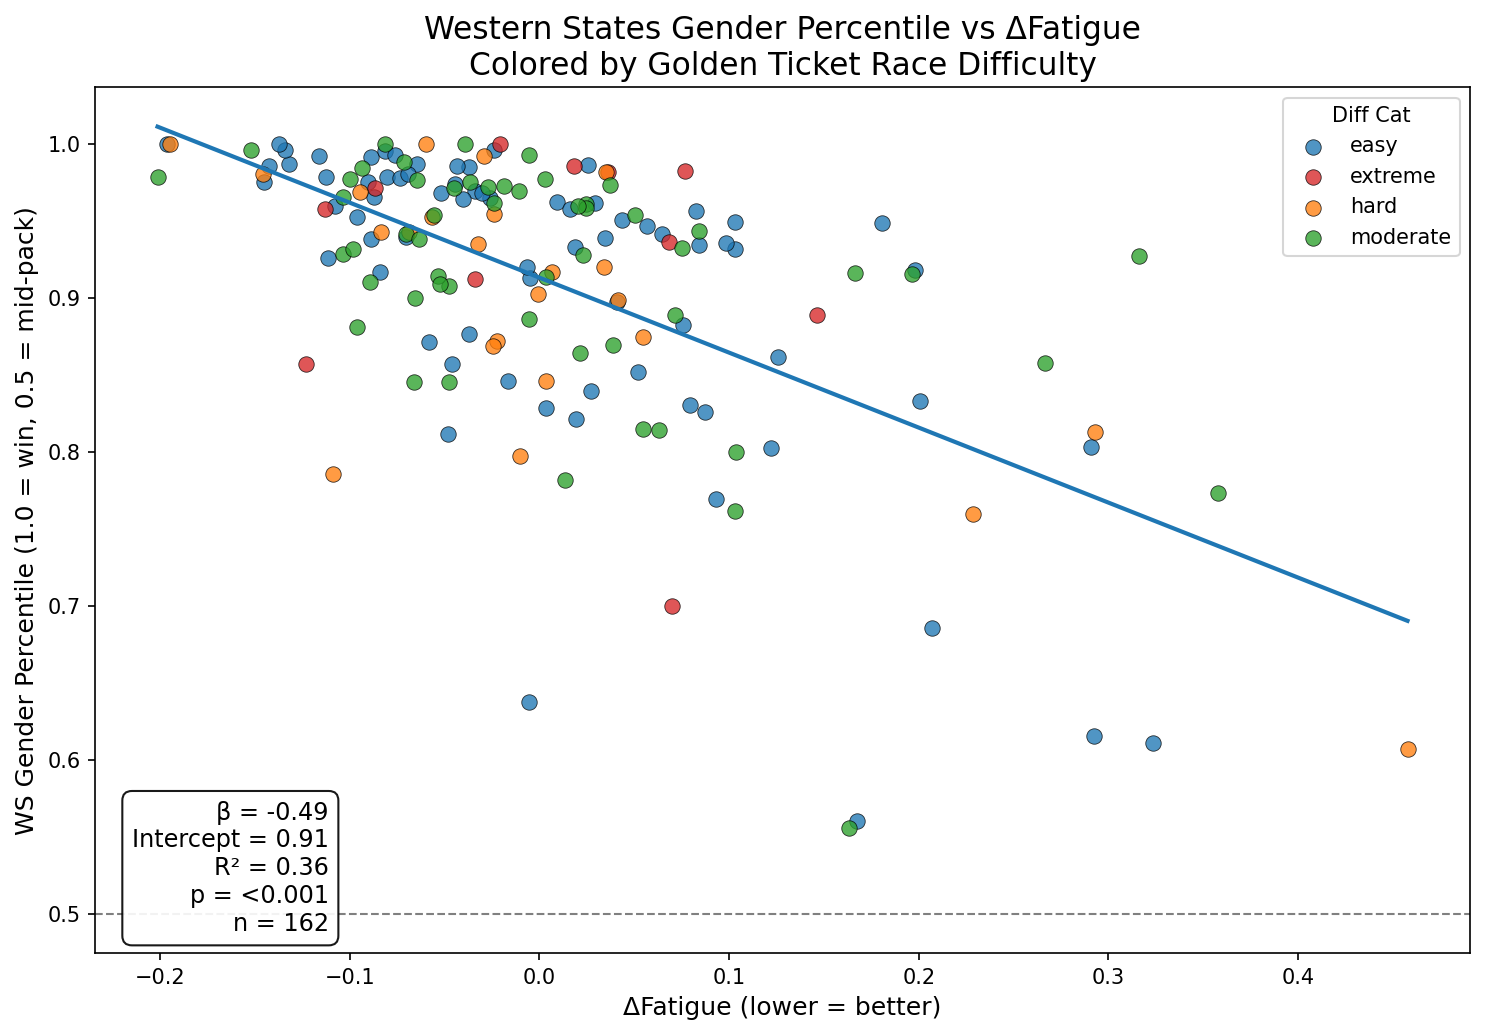

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1) Load dataset
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\master\master_csv\gt_master_table.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2) Normalize core fields and times
# -------------------------------------------------------------------
df["Gender_Rank"] = pd.to_numeric(df["Gender_Rank"], errors="coerce")
df["WS_Gender_Rank"] = pd.to_numeric(df["WS_Gender_Rank"], errors="coerce")

# Difficulty index
if "Diff_Index" in df.columns:
    df["Diff_Index"] = pd.to_numeric(df["Diff_Index"], errors="coerce")
elif "gt_diff_index" in df.columns:
    df["Diff_Index"] = pd.to_numeric(df["gt_diff_index"], errors="coerce")
else:
    raise ValueError("No difficulty index column found (expected 'Diff_Index' or 'gt_diff_index').")

# Time conversion helper
def to_seconds(t):
    if pd.isna(t):
        return np.nan
    s = str(t)
    if ":" in s:
        try:
            h, m, sec = s.split(":")
            return int(h)*3600 + int(m)*60 + float(sec)
        except Exception:
            return np.nan
    # Excel fraction-of-day numeric
    try:
        return float(s) * 24 * 3600
    except Exception:
        return np.nan

df["gt_sec"] = df["GT_Finish_Time"].apply(to_seconds)
df["ws_sec"] = df["WS_Finish_Time"].apply(to_seconds)

# Distances (km) - using Actual_Dist (miles) from gt_master_table
df["gt_distance_km"] = df["Actual_Dist"] * 1.60934
df["ws_distance_km"] = 160.9  # Western States ~100.1 miles

df = df.dropna(subset=["gt_distance_km"])

# -------------------------------------------------------------------
# 4.5) Compute Soft-Floor Adjusted Log Scale for Difficulty
# -------------------------------------------------------------------
LOG_OFFSET = 20  # Prevents log(0) and reduces compression of lower values
log_min = np.log(df["Diff_Index"].min() + LOG_OFFSET)
log_max = np.log(df["Diff_Index"].max() + LOG_OFFSET)

df["Log_Scale"] = ((np.log(df["Diff_Index"] + LOG_OFFSET) - log_min) / (log_max - log_min)) * 100

# Apply soft floor adjustment to set minimum at 5
current_min = df["Log_Scale"].min()
shift_amount = 5 - current_min
df["Log_Scale"] = df["Log_Scale"] + shift_amount
# -------------------------------------------------------------------
# Map Log_Scale into the SAME bins as your bar chart
#   5–19  = Easy
#   20–39 = Moderate
#   40–69 = Hard
#   70+   = Extreme
# -------------------------------------------------------------------
def map_category(val):
    if pd.isna(val):
        return np.nan
    v = float(val)
    if v >= 70:
        return "Extreme"
    elif v >= 40:
        return "Hard"
    elif v >= 20:
        return "Moderate"
    elif v >= 5:
        return "Easy"
    else:
        return np.nan

df["Race_Category"] = df["Log_Scale"].apply(map_category)

# -------------------------------------------------------------------
# Race_Style bands derived from the SAME Log_Scale bins
#    Easy      → fast
#    Moderate  → moderate
#    Hard      → challenging
#    Extreme   → extreme
# -------------------------------------------------------------------
def map_style_from_log(val):
    if pd.isna(val):
        return np.nan
    v = float(val)
    if v >= 70:        # Extreme
        return "extreme"
    elif v >= 40:      # Hard
        return "hard"   # or "severe" if you like that label better
    elif v >= 20:      # Moderate
        return "moderate"
    elif v >= 5:       # Easy
        return "easy"
    else:
        return np.nan

df["Race_Style"] = df["Log_Scale"].apply(map_style_from_log)
df = df.dropna(subset=["Race_Style"])

# Create dummy variables (using "easy" as reference category)
style_dummies = pd.get_dummies(df["Race_Style"], prefix="style", dtype=float)
if "style_easy" in style_dummies.columns:
    style_dummies = style_dummies.drop(columns=["style_easy"])

df = pd.concat([df, style_dummies], axis=1)


# -------------------------------------------------------------------
# 5) Fit gender-specific Riegel model with style + log-scaled difficulty
# -------------------------------------------------------------------
params_by_gender = {}
style_cols = [c for c in df.columns if c.startswith("style_")]

for g in ["M", "F"]:
    sub = df[df["Gender"] == g].dropna(
        subset=["gt_sec", "ws_sec", "gt_distance_km", "Log_Scale"]
    ).copy()
    if sub.empty:
        continue
    
    sub["log_ratio"] = np.log(sub["ws_sec"] / sub["gt_sec"])
    sub["log_dist_ratio"] = np.log(160.9 / sub["gt_distance_km"])
    
    X_cols = ["log_dist_ratio", "Log_Scale"] + style_cols
    X = sub[X_cols].astype(float)
    X = sm.add_constant(X)
    y = sub["log_ratio"].astype(float)
    
    res = sm.OLS(y, X).fit()
    params = dict(res.params)
    
    params_by_gender[g] = {
        "alpha": params["const"],
        "k": params["log_dist_ratio"],
        "beta_diff": params["Log_Scale"],
        "gamma_styles": {c: params.get(c, 0.0) for c in style_cols},
        "summary": res.summary().as_text(),
    }
    
    print(f"\n=== Riegel+Style for {g} ===")
    print(f"k={params['log_dist_ratio']:.3f}, "
          f"beta_log_scale={params['Log_Scale']:.4f}, "
          f"alpha={params['const']:.4f}, "
          f"R²={res.rsquared:.2f}")

# -------------------------------------------------------------------
# 6) Define prediction function and compute ΔFatigue
# -------------------------------------------------------------------
def predict_ws_time_style(row):
    p = params_by_gender.get(row["Gender"])
    if (
        p is None
        or pd.isna(row["gt_sec"])
        or pd.isna(row["Log_Scale"])
        or pd.isna(row["gt_distance_km"])
    ):
        return np.nan
    
    log_dist = np.log(row["ws_distance_km"] / row["gt_distance_km"])
    log_ratio = (
        p["alpha"] 
        + p["k"] * log_dist 
        + p["beta_diff"] * row["Log_Scale"]
    )
    
    for sc in style_cols:
        log_ratio += p["gamma_styles"].get(sc, 0.0) * row.get(sc, 0.0)
    
    ratio = np.exp(log_ratio)
    return row["gt_sec"] * ratio

# NOW apply the predictions
df["ws_pred_sec_style"] = df.apply(predict_ws_time_style, axis=1)
df["delta_fatigue_style"] = (
    df["ws_sec"] - df["ws_pred_sec_style"]
) / df["ws_pred_sec_style"]

# Sanity check
assert (df["ws_pred_sec_style"].dropna() > 0).all(), "Negative predicted times detected"

# -------------------------------------------------------------------
# MODEL VALIDATION
# -------------------------------------------------------------------
print("\n" + "="*70)
print("MODEL VALIDATION CHECKS")
print("="*70)

validation = df[df["ws_pred_sec_style"].notna()].copy()
validation["ws_pred_hours"] = validation["ws_pred_sec_style"] / 3600
validation["ws_actual_hours"] = validation["ws_sec"] / 3600
validation["error_hours"] = validation["ws_actual_hours"] - validation["ws_pred_hours"]

print("\n1. OVERALL ACCURACY:")
print(f"   Mean Absolute Error: {validation['error_hours'].abs().mean():.2f} hours")
print(f"   Median Absolute Error: {validation['error_hours'].abs().median():.2f} hours")
print(f"   Mean Predicted: {validation['ws_pred_hours'].mean():.2f} hours")
print(f"   Mean Actual: {validation['ws_actual_hours'].mean():.2f} hours")

print("\n2. SAMPLE PREDICTIONS:")
sample = validation.sample(min(10, len(validation)))
for _, row in sample.iterrows():
    print(f"   {row['Race_Name'][:20]:20s} | Pred: {row['ws_pred_hours']:5.2f}h | Actual: {row['ws_actual_hours']:5.2f}h | Error: {row['error_hours']:+5.2f}h")

print("\n3. BIAS CHECK BY DIFFICULTY:")
for style in ["easy", "moderate", "hard", "extreme"]:
    sub = validation[validation["Race_Style"] == style]
    if len(sub) > 0:
        print(f"   {style.capitalize():10s}: mean error = {sub['error_hours'].mean():+.2f}h (n={len(sub):3d})")

print("\n4. RIEGEL EXPONENT CHECK:")
for g in ["M", "F"]:
    k = params_by_gender[g]["k"]
    example_pred = 12 * (100.1/62.14)**k
    print(f"   {g}: k={k:.3f} | Example: 12h@100k → {example_pred:.1f}h@100mi")

# -------------------------------------------------------------------
# 7) Map total WS gender participants and compute WS percentile
# -------------------------------------------------------------------
ws_gender_totals_map = {
    (2016, "F"): 72,
    (2016, "M"): 264,
    (2017, "F"): 75,
    (2017, "M"): 275,
    (2018, "F"): 69,
    (2018, "M"): 285,
    (2019, "F"): 78,
    (2019, "M"): 273,
    (2021, "F"): 65,
    (2021, "M"): 235,
    (2022, "F"): 81,
    (2022, "M"): 281,
    (2023, "F"): 70,
    (2023, "M"): 283,
    (2024, "F"): 84,
    (2024, "M"): 262,
    (2025, "F"): 88,
    (2025, "M"): 257,
}

# Add total finishers per WS year + gender
df["ws_total_gender_participants"] = df.apply(
    lambda row: ws_gender_totals_map.get((row["WS_Year"], row["Gender"])),
    axis=1,
)

# Compute WS gender percentile: 1.0 = win, 0.0 = last place
df["ws_percentile"] = 1 - (
    (df["WS_Gender_Rank"] - 1) / df["ws_total_gender_participants"]
)

# Keep WS finishers only (percentile is only meaningful for finishers)
if "WS_Finisher_Flag" in df.columns:
    df = df[df["WS_Finisher_Flag"] == True]

# -------------------------------------------------------------------
# 8) Regression: ws_percentile ~ ΔFatigue_style (with data quality checks)
# -------------------------------------------------------------------
valid = df.dropna(subset=["delta_fatigue_style", "ws_percentile"]).copy()

# Remove based on data quality issues (not model fit)
# These thresholds identify likely data errors or extreme circumstances
data_quality_issues = (
    (valid["delta_fatigue_style"] < -0.5) |  # Unrealistically faster than predicted (>50% better)
    (valid["delta_fatigue_style"] > 1.5) |   # Unrealistically slower (>150% worse - likely injury/DNF miscoded)
    (valid["ws_percentile"] < 0) |           # Impossible percentile
    (valid["ws_percentile"] > 1)             # Impossible percentile
)

# Add after your model fitting section
print("\n=== Investigating Women's Model ===")
women_sub = df[df["Gender"] == "F"].dropna(
    subset=["gt_sec", "ws_sec", "gt_distance_km", "Log_Scale"]
).copy()

print(f"Sample size: {len(women_sub)}")
print(f"GT distance range: {women_sub['gt_distance_km'].min():.1f} to {women_sub['gt_distance_km'].max():.1f} km")
print(f"Mean GT distance: {women_sub['gt_distance_km'].mean():.1f} km")

# Check if there's enough distance variation
distance_std = women_sub['gt_distance_km'].std()
print(f"GT distance std dev: {distance_std:.1f} km")

if distance_std < 10:
    print("⚠️ WARNING: Low distance variation may cause unreliable k estimation")

print(f"\n=== Data Quality Check ===")
print(f"Total observations: {len(valid)}")

# Break down by type of issue
extreme_negative = (valid["delta_fatigue_style"] < -0.5).sum()
extreme_positive = (valid["delta_fatigue_style"] > 1.5).sum()
invalid_percentile = ((valid["ws_percentile"] < 0) | (valid["ws_percentile"] > 1)).sum()

print(f"\nData quality issues by type:")
print(f"  - Unrealistically fast (ΔFatigue < -0.5): {extreme_negative}")
print(f"  - Unrealistically slow (ΔFatigue > 1.5): {extreme_positive}")
print(f"  - Invalid percentile: {invalid_percentile}")
print(f"  - Total issues: {data_quality_issues.sum()}")
print(f"  - Retained for analysis: {len(valid) - data_quality_issues.sum()}")

if data_quality_issues.sum() > 0:
    print("\nDetails of removed observations:")
    print(valid[data_quality_issues][["Race_Name", "GT_Year", "Gender", "delta_fatigue_style", "ws_percentile"]].to_string())


valid_clean = valid[~data_quality_issues].copy()

# Fit model on clean data
X = sm.add_constant(valid_clean[["delta_fatigue_style"]])
y = valid_clean["ws_percentile"]

model = sm.OLS(y, X).fit()
print("\n=== ws_percentile ~ delta_fatigue_style (data quality filtered) ===")
print(model.summary())

# -------------------------------------------------------------------
# 9) Scatter plot: ΔFatigue vs WS percentile (style-coded, clean data)
# -------------------------------------------------------------------
m = model.params["delta_fatigue_style"]
b = model.params["const"]

x_line = np.linspace(
    valid_clean["delta_fatigue_style"].min(),
    valid_clean["delta_fatigue_style"].max(),
    250,
)
y_line = m * x_line + b

beta = m
intercept = b
r2 = model.rsquared
p = model.pvalues["delta_fatigue_style"]
n = valid_clean.shape[0]
p_text = f"{p:.3f}" if p >= 0.001 else "<0.001"

style_colors = {
    "easy": "tab:blue",
    "moderate": "tab:green",
    "hard": "tab:orange",
    "extreme": "tab:red",
}

plt.figure(figsize=(10, 7), dpi=150)

for style, sub in valid_clean.groupby("Race_Style"):
    plt.scatter(
        sub["delta_fatigue_style"],
        sub["ws_percentile"],
        s=55,
        alpha=0.78,
        edgecolors="black",
        linewidth=0.4,
        label=style,
        color=style_colors.get(style, "gray"),
    )

plt.plot(x_line, y_line, linewidth=2)
plt.axhline(0.5, linestyle="--", linewidth=1, color="gray")  # mid-pack reference

plt.xlabel("ΔFatigue (lower = better)", fontsize=12)
plt.ylabel("WS Gender Percentile (1.0 = win, 0.5 = mid-pack)", fontsize=12)
plt.title(
    "Western States Gender Percentile vs ΔFatigue\n"
    "Colored by Golden Ticket Race Difficulty",
    fontsize=15,
)

text_box = (
    f"β = {beta:.2f}\n"
    f"Intercept = {intercept:.2f}\n"
    f"R² = {r2:.2f}\n"
    f"p = {p_text}\n"
    f"n = {n}"
)

plt.text(
    0.17,
    0.02,
    text_box,
    transform=plt.gca().transAxes,
    fontsize=11.5,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9),
)

plt.legend(title="Diff Cat", fontsize=10)
plt.tight_layout()

plt.savefig('../python_images/regression_study.png', dpi = 300)

plt.show()

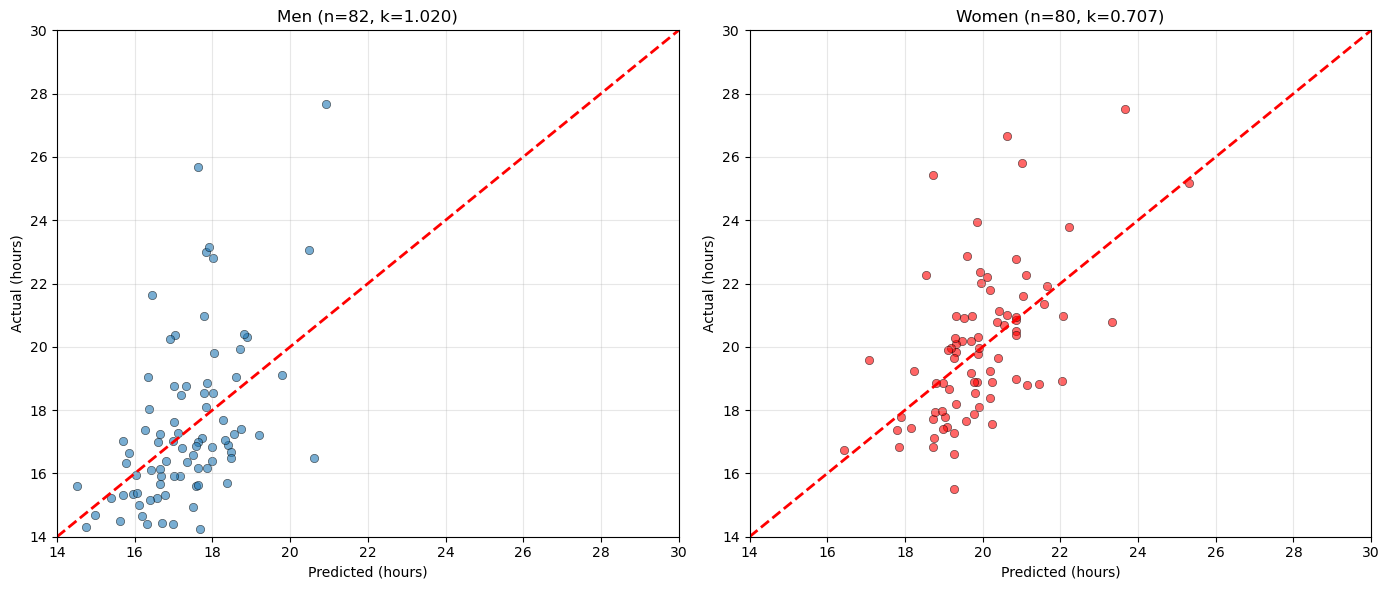

In [104]:
# Scatter: Predicted vs Actual, colored by gender
validation_clean = validation.dropna(subset=["ws_pred_hours", "ws_actual_hours"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Men
men_val = validation_clean[validation_clean["Gender"] == "M"]
ax1.scatter(men_val["ws_pred_hours"], men_val["ws_actual_hours"], 
           alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.plot([14, 30], [14, 30], 'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel("Predicted (hours)")
ax1.set_ylabel("Actual (hours)")
ax1.set_title(f"Men (n={len(men_val)}, k={params_by_gender['M']['k']:.3f})")
ax1.grid(True, alpha=0.3)
ax1.set_xlim(14, 30)
ax1.set_ylim(14, 30)

# Women
women_val = validation_clean[validation_clean["Gender"] == "F"]
ax2.scatter(women_val["ws_pred_hours"], women_val["ws_actual_hours"], 
           alpha=0.6, edgecolors='black', linewidth=0.5, color='red')
ax2.plot([14, 30], [14, 30], 'r--', linewidth=2, label='Perfect prediction')
ax2.set_xlabel("Predicted (hours)")
ax2.set_ylabel("Actual (hours)")
ax2.set_title(f"Women (n={len(women_val)}, k={params_by_gender['F']['k']:.3f})")
ax2.grid(True, alpha=0.3)
ax2.set_xlim(14, 30)
ax2.set_ylim(14, 30)

plt.tight_layout()
plt.show()